## Submission by
1. Aman (MDS202305)
2. Ankar Kar (MCS202303)
3. Utpalraj Kemprai (MDS202352)

## Data and Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy, random

torch.manual_seed(14)
random.seed(14)
numpy.random.seed(14)


# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the Fashion MNIST dataset

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 3      # there are 3 classes (clothes, shoes, others)

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True,
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12503799.15it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 194921.26it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3595050.82it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6078906.81it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
print(f"Training data size: {len(train_loader.dataset)}")
print(f"Test data size: {len(test_loader.dataset)}")


Training data size: 60000
Test data size: 10000


### Viewing the Fashion MNIST dataset

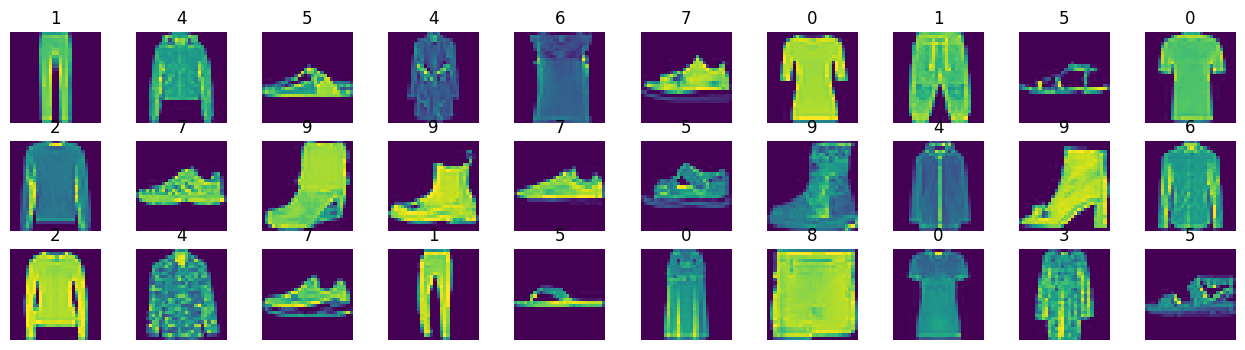

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(30):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(3, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

### Relabeling the dataset

In [ ]:
# Re-labeling function
def relabel(target):
    if target in [0, 1, 2, 3, 4, 6]:  # Clothes
        return 0
    elif target in [5, 7, 9]:  # Shoes
        return 1
    else:  # Others (8 for Bags)
        return 2

# Apply relabeling to train and test sets
train_loader.dataset.targets = torch.tensor([relabel(label) for label in train_loader.dataset.targets]) # Access the dataset object within the DataLoader
test_loader.dataset.targets = torch.tensor([relabel(label) for label in test_loader.dataset.targets]) # Access the dataset object within the DataLoader

### Viewing the images after relabeling

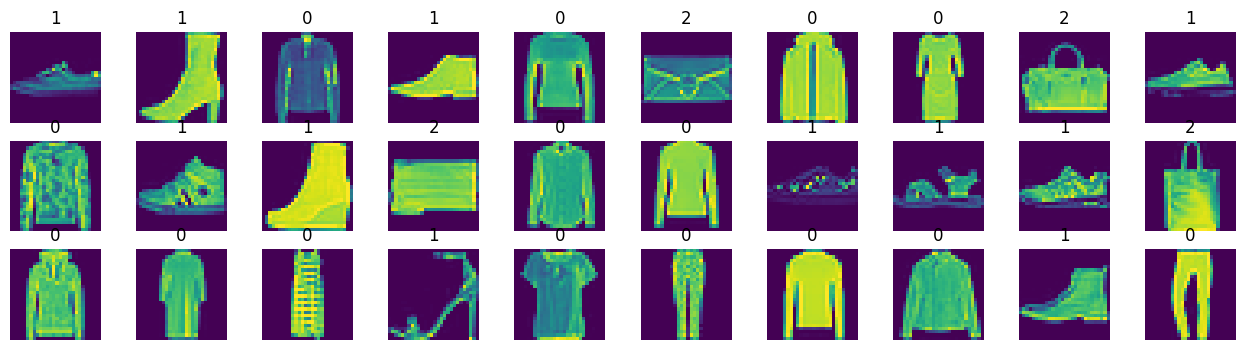

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(30):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(3, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

## Helper functions for training and testing

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## The Convolutional Network

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

## Training the network

In [ ]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.198252
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.327285
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.064688
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.061652
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.020075
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.301595
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.041074
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.094187
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.035704
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.037714

Test set: Average loss: 0.0631, Accuracy: 9813/10000 (98.13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130862
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.043427
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.071182
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.072562
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.041150
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.048438
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.049312
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.053897


## Performance on the test data

In [ ]:
test(model_cnn)


Test set: Average loss: 0.0280, Accuracy: 9920/10000 (99.20%)



## Effect of permuting the image pixels on CNN classifiers for Fashion MNIST

### Visualizing some permuted images

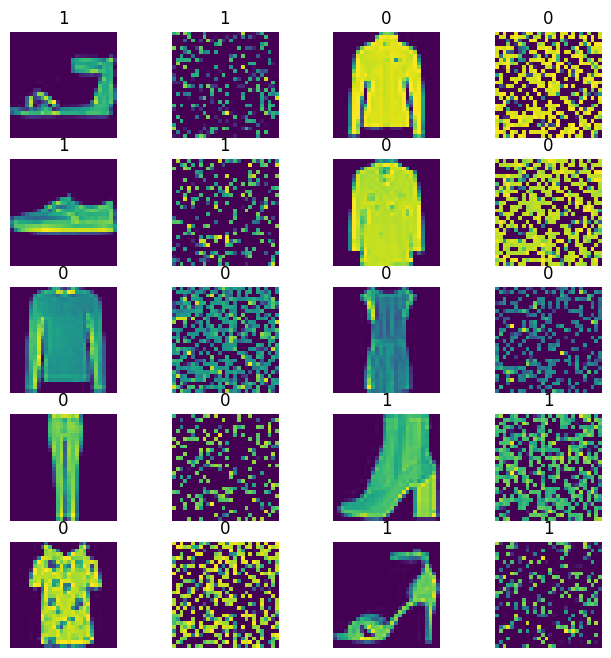

In [ ]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(10):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    label = label_batch[i].item()
    plt.subplot(5,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(5, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

## Helper functions for training and testing on the scrambled images

In [ ]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


## Training the network on the scrambled data

In [ ]:
print("Training on ", device)
model_cnn_2 = CNN(input_size, output_size)
model_cnn_2.to(device)
optimizer = optim.SGD(model_cnn_2.parameters(), lr=0.001, momentum=0.9)
print('Number of parameters: {}'.format(get_n_params(model_cnn_2)))

for epoch in range(10):
    scramble_train(epoch, model_cnn_2, fixed_perm)
    scramble_test(model_cnn_2, fixed_perm)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292233
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.745167
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.236023
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.102954
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.050496
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.047319
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.043517
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.044053
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.068120
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.011660

Test set: Average loss: 0.0581, Accuracy: 9803/10000 (98.03%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.078083
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.016091
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.065320
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.094832
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.159773
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.043131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.005926
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.018371


In [ ]:
scramble_test(model_cnn_2, fixed_perm)


Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)

